# Navier Stokes Equatoin

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la

# --- Core imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div
)
from pycutfem.ufl.measures import dx
from pycutfem.ufl.forms import BoundaryCondition, assemble_form
from pycutfem.fem.mixedelement import MixedElement

# 1. ============================================================================
#    SETUP (Meshes, DofHandler, BCs)
# ===============================================================================
L, H = 1.0, 1.0
NX, NY = 16, 6 # Increased resolution for better visualization
nodes_q2, elems_q2, _, corners_q2 = structured_quad(L, H, nx=NX, ny=NY, poly_order=2)
mesh_q2 = Mesh(nodes=nodes_q2, element_connectivity=elems_q2, elements_corner_nodes=corners_q2, element_type="quad", poly_order=2)
mixed_element = MixedElement(mesh_q2, field_specs={'ux': 2, 'uy': 2, 'p': 1})

dof_handler = DofHandler(mixed_element, method='cg')


# Tag boundaries for applying BCs
bc_tags = {
    'bottom_wall': lambda x,y: np.isclose(y,0),
    'left_wall':   lambda x,y: np.isclose(x,0),
    'right_wall':  lambda x,y: np.isclose(x,L),
    'top_lid':     lambda x,y: np.isclose(y,H)
}
mesh_q2.tag_boundary_edges(bc_tags)

# Tag a single node for pressure pinning
dof_handler.tag_dof_by_locator(
        tag='pressure_pin_point',
        field='p',
        locator=lambda x, y: np.isclose(x, 0) and np.isclose(y, 0),
        find_first=True
    )

class DataBC:
    Um = 1.5 # Lid velocity
    H = H
    T = 2.0 # Total time for simulation
    
# bcs = [
#     # No-slip on bottom, left, and right walls
#     BoundaryCondition('ux', 'dirichlet', 'bottom_wall', lambda x,y:0.0),
#     BoundaryCondition('uy', 'dirichlet', 'bottom_wall', lambda x,y:0.0),
#     BoundaryCondition('ux', 'dirichlet', 'left_wall',   lambda x,y: 4 * DataBC.Um * y * (DataBC.H-y) / (DataBC.H**2)),
#     BoundaryCondition('uy', 'dirichlet', 'left_wall',   lambda x,y:0.0),
#     BoundaryCondition('ux', 'dirichlet', 'right_wall',  lambda x,y:0.0),
#     BoundaryCondition('uy', 'dirichlet', 'right_wall',  lambda x,y:0.0),
#     # Moving lid on the top wall
#     BoundaryCondition('ux', 'dirichlet', 'top_lid',     lambda x,y:0.0),
#     BoundaryCondition('uy', 'dirichlet', 'top_lid',    lambda x,y:0.0),
#     # Pin pressure at one point to ensure a unique solution
#     BoundaryCondition('p', 'dirichlet', 'pressure_pin_point',lambda x,y: 0.0)
# ]
t=0.0

bcs = [
    # No-slip on bottom, left, and right walls
    BoundaryCondition('ux', 'dirichlet', 'bottom_wall', lambda x,y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'bottom_wall', lambda x,y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'left_wall',   lambda x,y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'left_wall',   lambda x,y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'right_wall',  lambda x,y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'right_wall',  lambda x,y: 0.0),
    # Moving lid on the top wall
    BoundaryCondition('ux', 'dirichlet', 'top_lid',     lambda x,y: DataBC.Um * np.sin(t * np.pi)), # Corrected: Was 0.0
    BoundaryCondition('uy', 'dirichlet', 'top_lid',     lambda x,y: 0.0),
    # Pin pressure at one point to ensure a unique solution
    BoundaryCondition('p', 'dirichlet', 'pressure_pin_point', lambda x,y: 0.0)
]

# Create the corresponding homogeneous BCs for the Newton update
bcs_homog = [
    BoundaryCondition(bc.field, bc.method, bc.domain_tag,lambda x,y: 0.0) for bc in bcs
]

print(f"Naviver info: {dof_handler.info()}")

=== DofHandler (CG) ===
        ux: 429 DOFs @ offset 0
        uy: 429 DOFs @ offset 9
         p: 119 DOFs @ offset 18
  total : 977
Naviver info: None


In [2]:
# 2. ============================================================================
#    UFL FORMULATION
# ===============================================================================

# --- Define Constants and Function Spaces ---
rho = Constant(1.0)
dt = Constant(0.1)
theta = Constant(0.5) # Crank-Nicolson
mu = Constant(1.0e-1)

velocity_space = FunctionSpace("velocity", ['ux', 'uy'])
pressure_space = FunctionSpace("pressure", ['p'])

# --- Define all required UFL Functions ---
# Trial functions for the Jacobian system (the corrections)
du = VectorTrialFunction(velocity_space, dof_handler=dof_handler)
dp = TrialFunction(pressure_space, dof_handler=dof_handler)

# Test functions
v = VectorTestFunction(velocity_space, dof_handler=dof_handler)
q = TestFunction(pressure_space, dof_handler=dof_handler)

# Functions to hold solutions at different time steps/iterations
# u_k/p_k are the current Newton iteration k at time t_n+1
# u_n/p_n are the converged solution from the previous time step t_n
u_k = VectorFunction(name="u_k", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_k = Function(name="p_k", field_name='p', dof_handler=dof_handler)
u_n = VectorFunction(name="u_n", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_n = Function(name="p_n", field_name='p', dof_handler=dof_handler)

# --- Define Residual R(u_k, p_k) and Jacobian J ---
# The residual is the transient Navier-Stokes equation F(U_k) = 0
# where U_k = (u_k, p_k)

In [3]:


jacobian = (
    # Time derivative term: d/dt(u) -> du/dt
    rho * dot(du, v) / dt  
    
    # Convection term: theta * [ ((du ⋅ ∇)u_k) ⋅ v + ((u_k ⋅ ∇)du) ⋅ v ]
    +theta * rho * dot(dot(grad(u_k),du ) , v)  
    +theta * rho * dot(dot(grad(du),u_k ), v)   

    # Diffusion term: theta * mu * (∇du : ∇v)
    +theta * mu * inner(grad(du), grad(v)) 
    
    # Pressure term: -theta * dp * (∇⋅v)
    -dp * div(v)  
    
    # Continuity term: q * (∇⋅du)
    +q * div(du) 
) * dx()

residual = (
    # Time derivative: -(u_k - u_n)/dt ⋅ v
    rho * dot(u_k - u_n, v) / dt  
    + (rho*theta) * dot(  dot(grad(u_k),u_k ) , v) 
    + (rho - (rho*theta)) * dot(   dot(grad(u_n),u_n   ) , v) 
    # Diffusion terms at theta and (1-theta)
    +(theta * mu * inner(grad(u_k), grad(v)) ) 
    +((1.0 - theta) * mu * inner(grad(u_n), grad(v)) ) 
    
    # Pressure terms
    - p_k * div(v) 
    # Continuity term
    +q * div(u_k)  
    
    ) * dx()



Applying initial boundary conditions...

--- Solving Time Step 1/20 | t = 0.10s ---
  Newton iteration 1
    Residual Norm: 5.925e-02
  Newton iteration 2
    Residual Norm: 2.141e-04
  Newton iteration 3
    Residual Norm: 3.276e-09
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

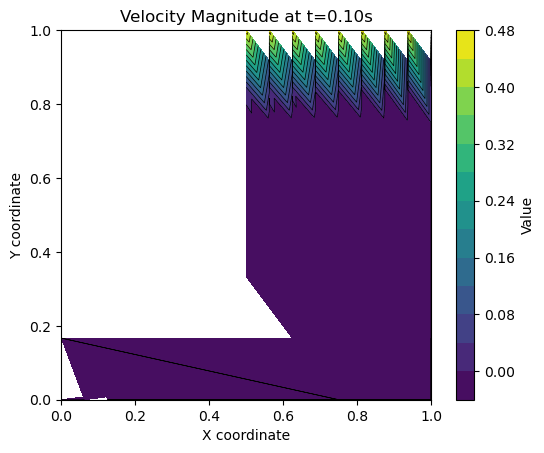

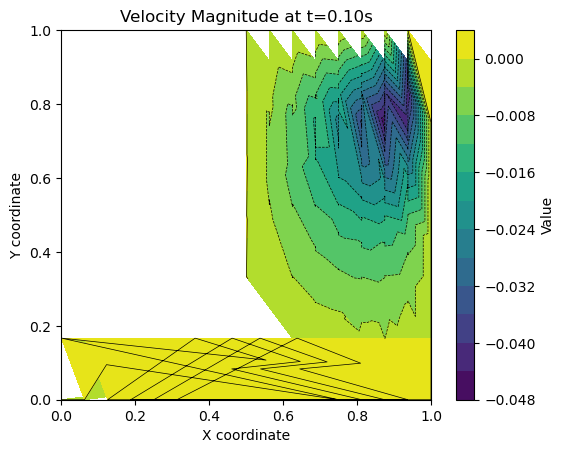


--- Solving Time Step 2/20 | t = 0.20s ---
  Newton iteration 1
    Residual Norm: 1.207e-01
  Newton iteration 2
    Residual Norm: 9.640e-04
  Newton iteration 3
    Residual Norm: 6.532e-08
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

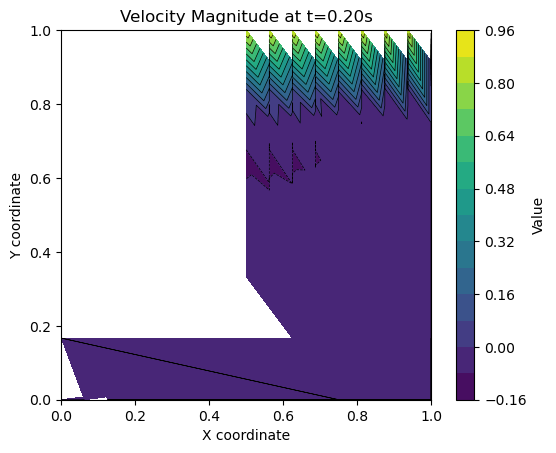

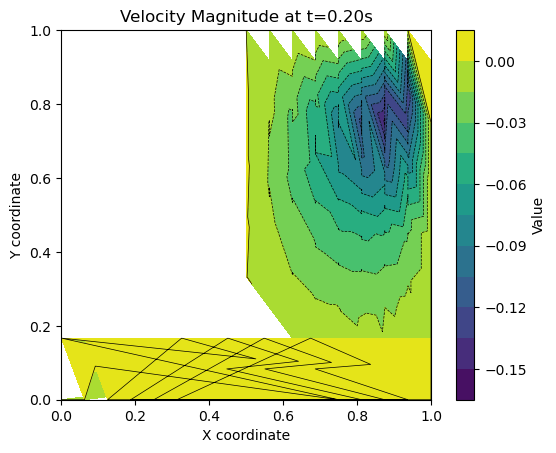


--- Solving Time Step 3/20 | t = 0.30s ---
  Newton iteration 1
    Residual Norm: 9.550e-02
  Newton iteration 2
    Residual Norm: 7.531e-04
  Newton iteration 3
    Residual Norm: 3.552e-08
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

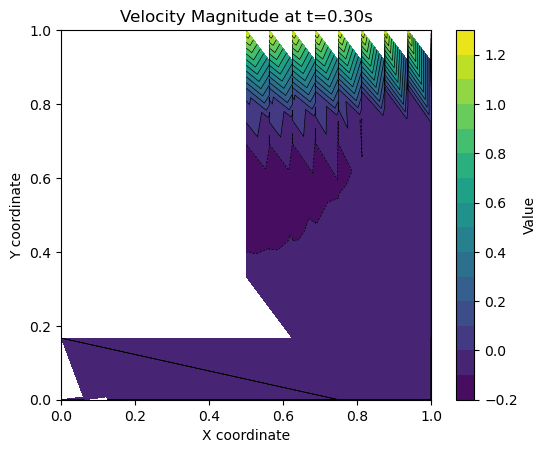

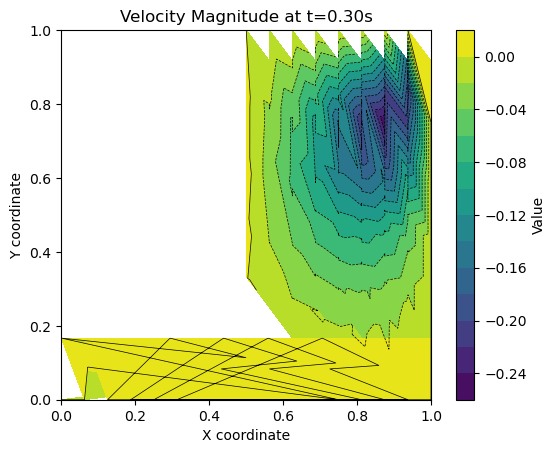


--- Solving Time Step 4/20 | t = 0.40s ---
  Newton iteration 1
    Residual Norm: 7.624e-02
  Newton iteration 2
    Residual Norm: 5.014e-04
  Newton iteration 3
    Residual Norm: 1.249e-08
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

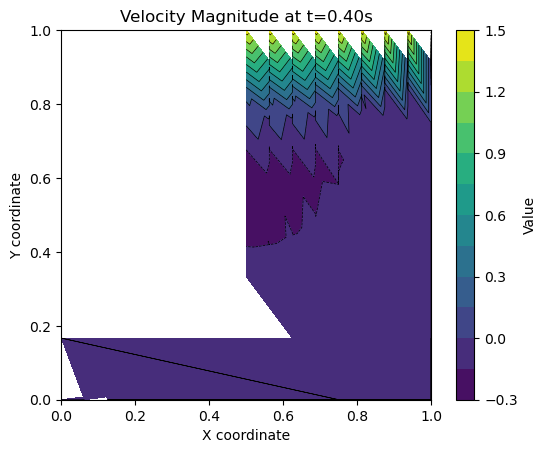

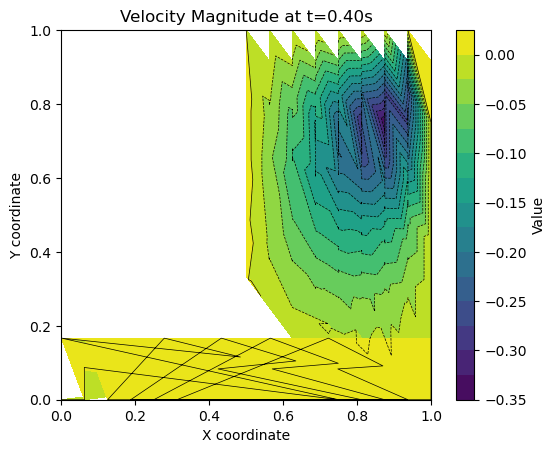


--- Solving Time Step 5/20 | t = 0.50s ---
  Newton iteration 1
    Residual Norm: 4.148e-02
  Newton iteration 2
    Residual Norm: 2.092e-04
  Newton iteration 3
    Residual Norm: 1.853e-09
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

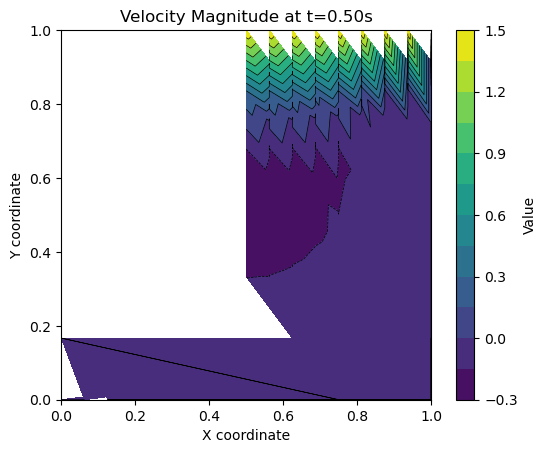

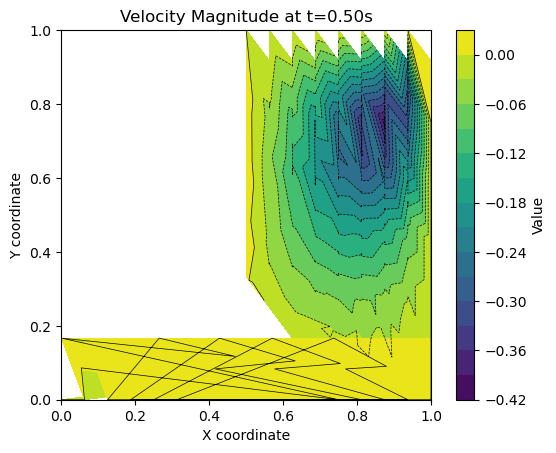


--- Solving Time Step 6/20 | t = 0.60s ---
  Newton iteration 1
    Residual Norm: 1.323e-02
  Newton iteration 2
    Residual Norm: 4.792e-05
  Newton iteration 3
    Residual Norm: 5.580e-11
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

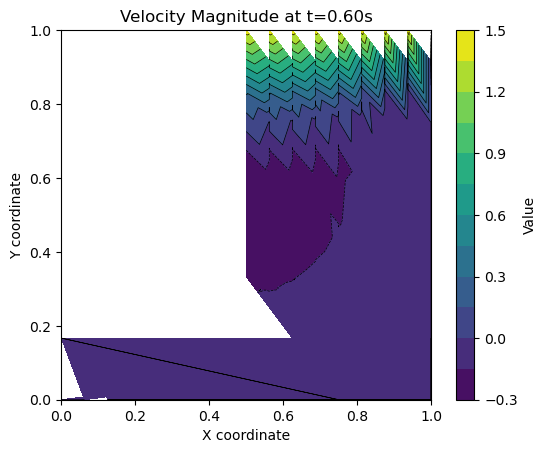

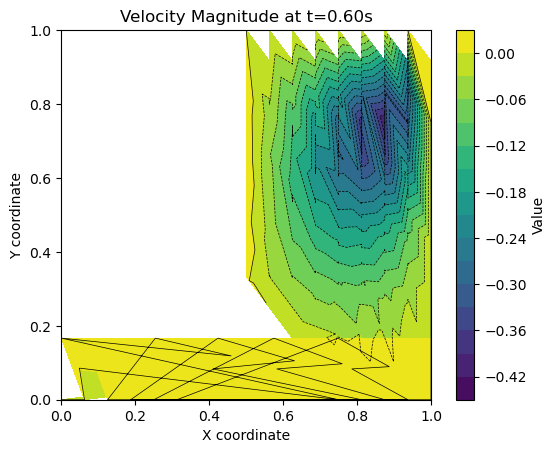


--- Solving Time Step 7/20 | t = 0.70s ---
  Newton iteration 1
    Residual Norm: 3.825e-02
  Newton iteration 2
    Residual Norm: 7.738e-05
  Newton iteration 3
    Residual Norm: 3.025e-10
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

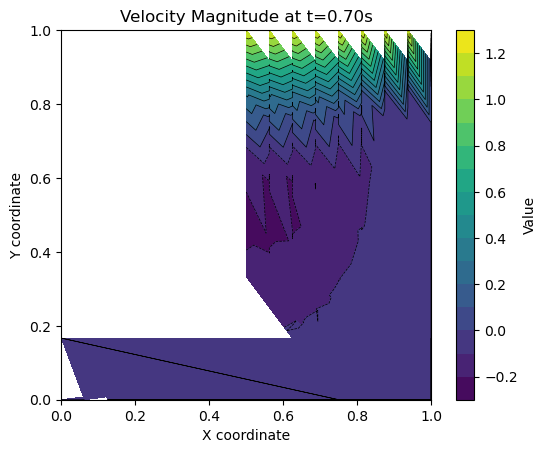

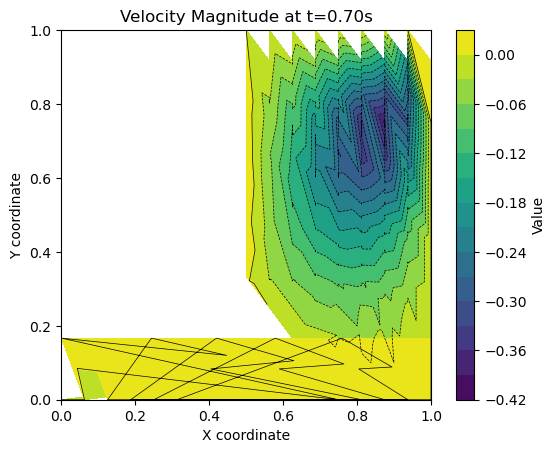


--- Solving Time Step 8/20 | t = 0.80s ---
  Newton iteration 1
    Residual Norm: 7.043e-02
  Newton iteration 2
    Residual Norm: 3.220e-04
  Newton iteration 3
    Residual Norm: 6.798e-09
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

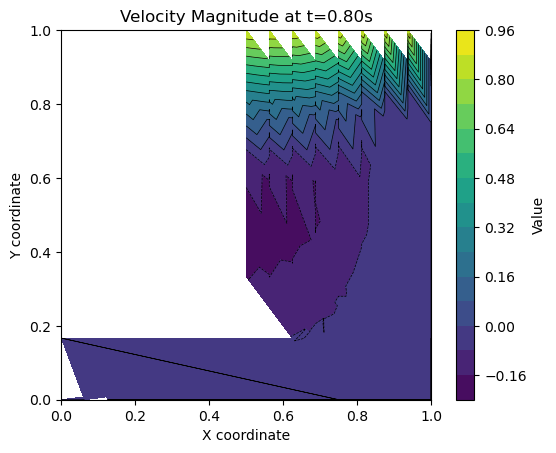

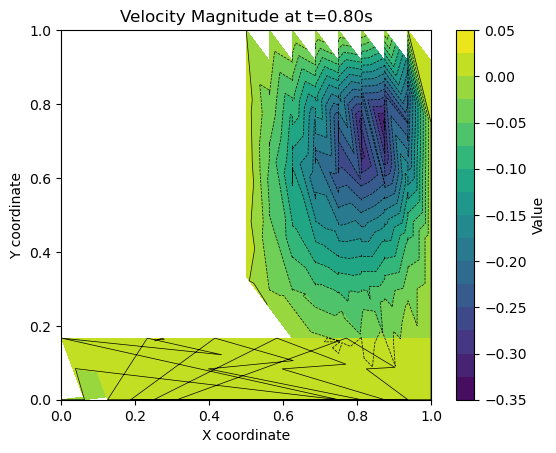


--- Solving Time Step 9/20 | t = 0.90s ---
  Newton iteration 1
    Residual Norm: 9.863e-02
  Newton iteration 2
    Residual Norm: 6.742e-04
  Newton iteration 3
    Residual Norm: 2.920e-08
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

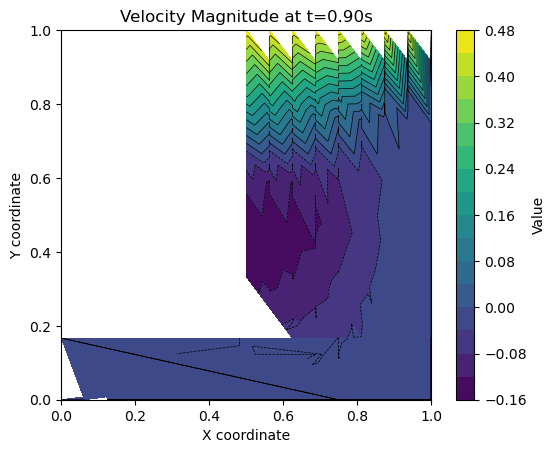

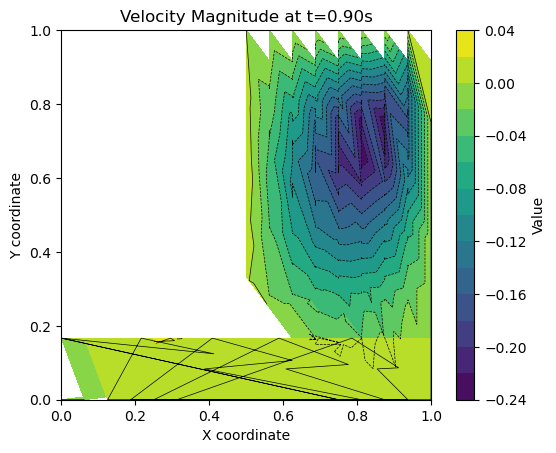


--- Solving Time Step 10/20 | t = 1.00s ---
  Newton iteration 1
    Residual Norm: 1.161e-01
  Newton iteration 2
    Residual Norm: 9.961e-04
  Newton iteration 3
    Residual Norm: 6.404e-08
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

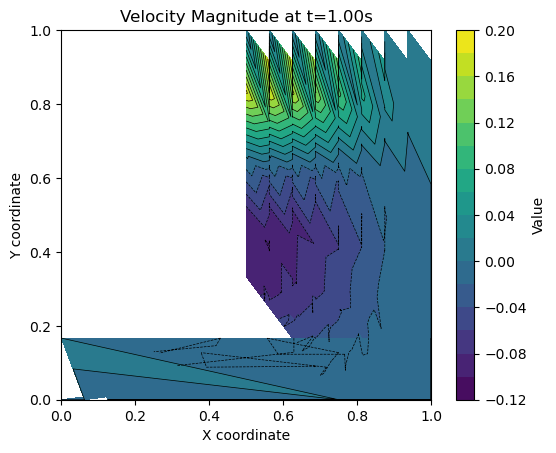

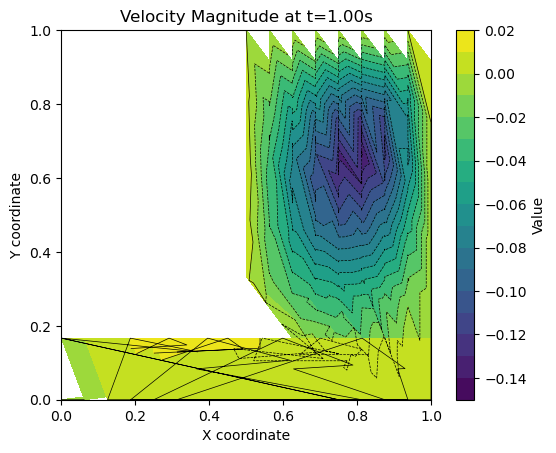


--- Solving Time Step 11/20 | t = 1.10s ---
  Newton iteration 1
    Residual Norm: 1.232e-01
  Newton iteration 2
    Residual Norm: 1.172e-03
  Newton iteration 3
    Residual Norm: 8.564e-08
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

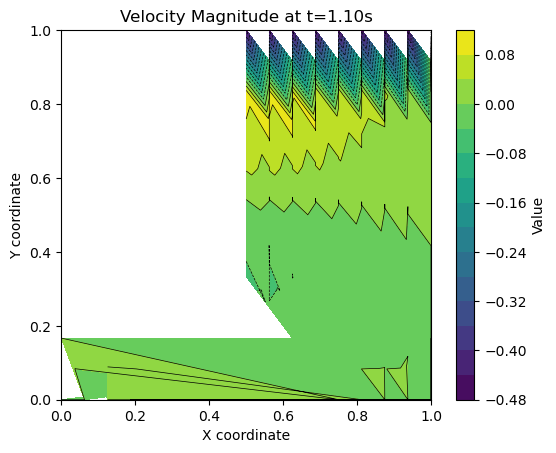

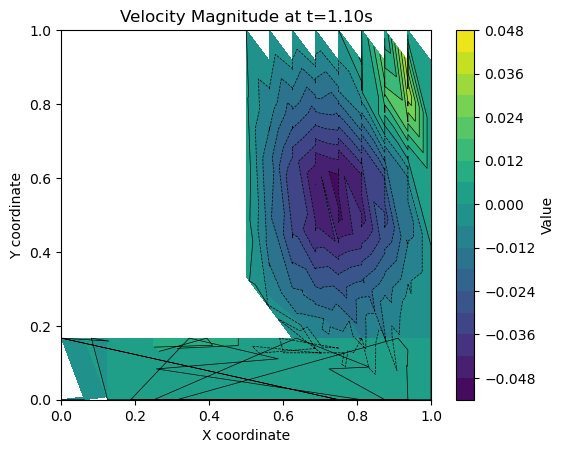


--- Solving Time Step 12/20 | t = 1.20s ---
  Newton iteration 1
    Residual Norm: 1.179e-01
  Newton iteration 2
    Residual Norm: 1.134e-03
  Newton iteration 3
    Residual Norm: 7.800e-08
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

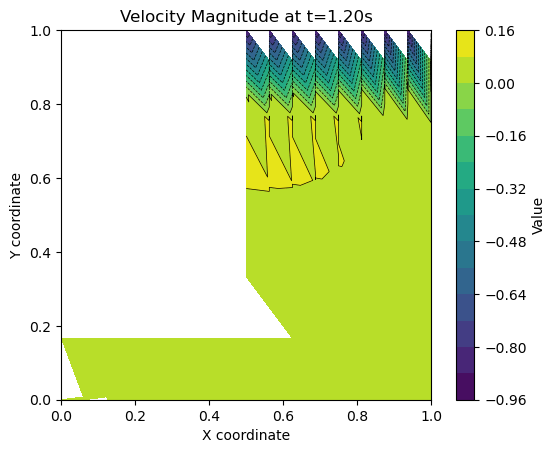

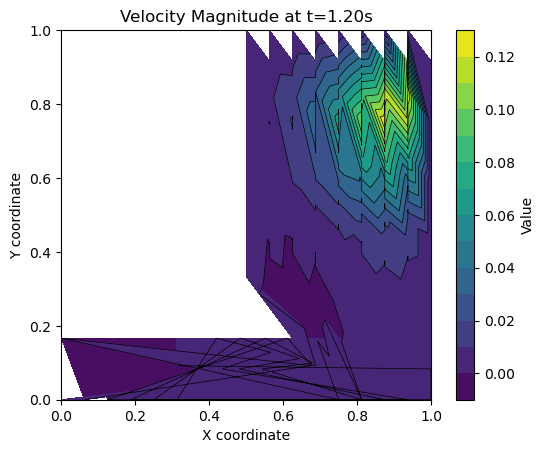


--- Solving Time Step 13/20 | t = 1.30s ---
  Newton iteration 1
    Residual Norm: 1.018e-01
  Newton iteration 2
    Residual Norm: 8.987e-04
  Newton iteration 3
    Residual Norm: 4.540e-08
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

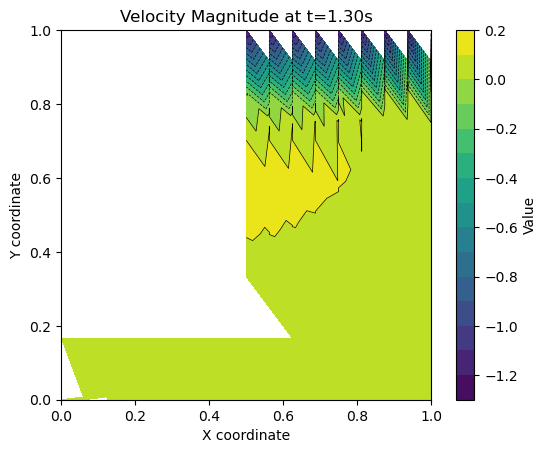

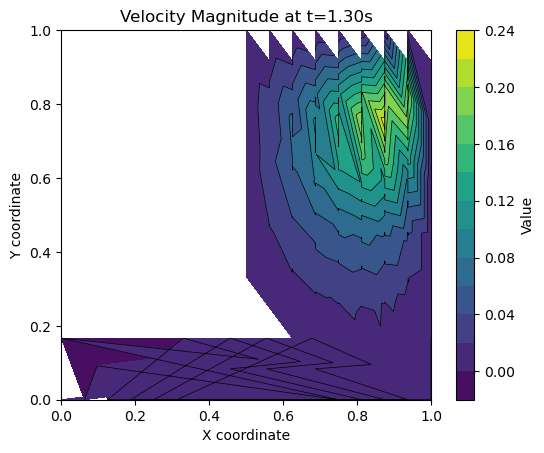


--- Solving Time Step 14/20 | t = 1.40s ---
  Newton iteration 1
    Residual Norm: 7.592e-02
  Newton iteration 2
    Residual Norm: 5.538e-04
  Newton iteration 3
    Residual Norm: 1.520e-08
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

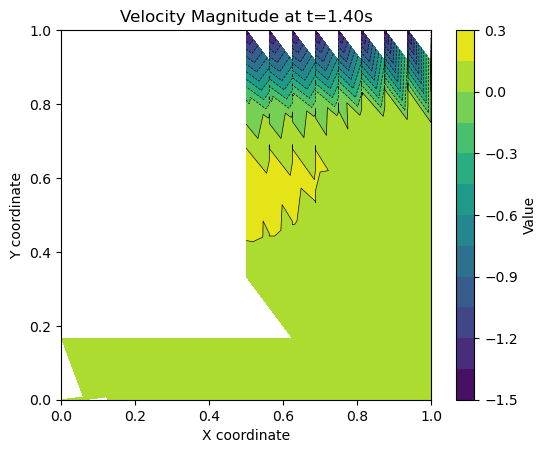

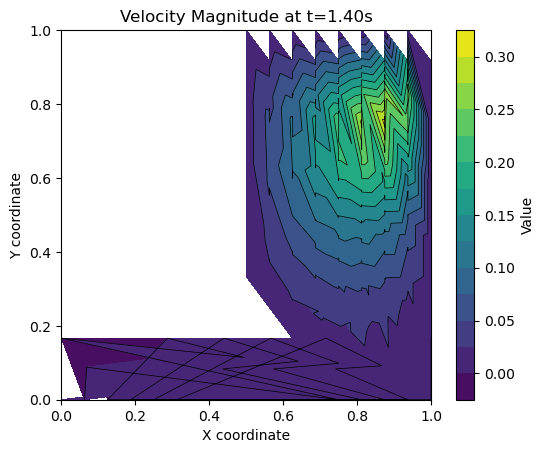


--- Solving Time Step 15/20 | t = 1.50s ---
  Newton iteration 1
    Residual Norm: 4.355e-02
  Newton iteration 2
    Residual Norm: 2.324e-04
  Newton iteration 3
    Residual Norm: 1.863e-09
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

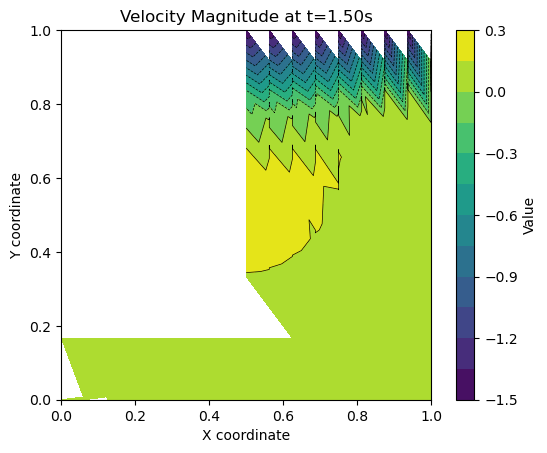

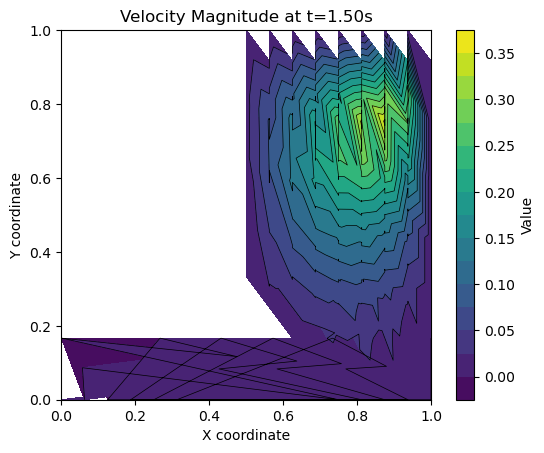


--- Solving Time Step 16/20 | t = 1.60s ---
  Newton iteration 1
    Residual Norm: 1.474e-02
  Newton iteration 2
    Residual Norm: 5.774e-05
  Newton iteration 3
    Residual Norm: 7.296e-11
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

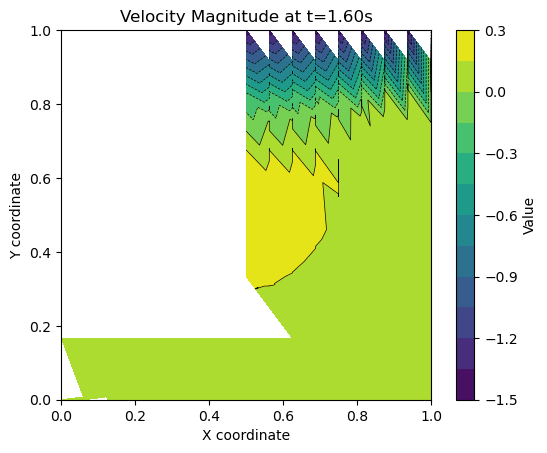

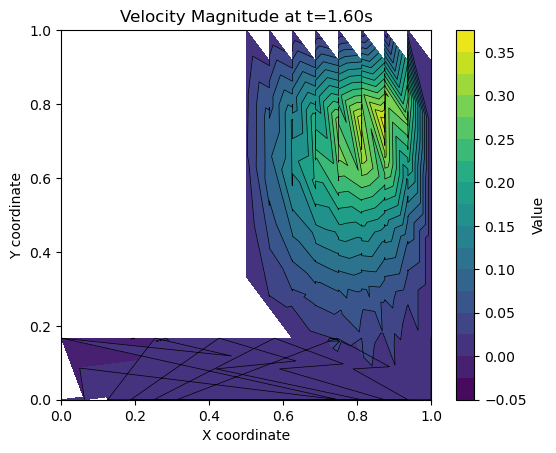


--- Solving Time Step 17/20 | t = 1.70s ---
  Newton iteration 1
    Residual Norm: 3.741e-02
  Newton iteration 2
    Residual Norm: 7.524e-05
  Newton iteration 3
    Residual Norm: 2.718e-10
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

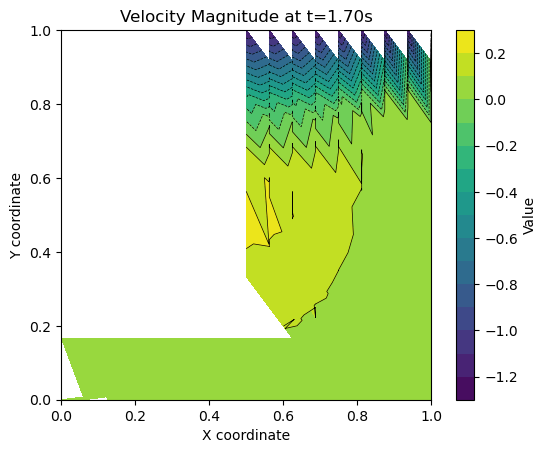

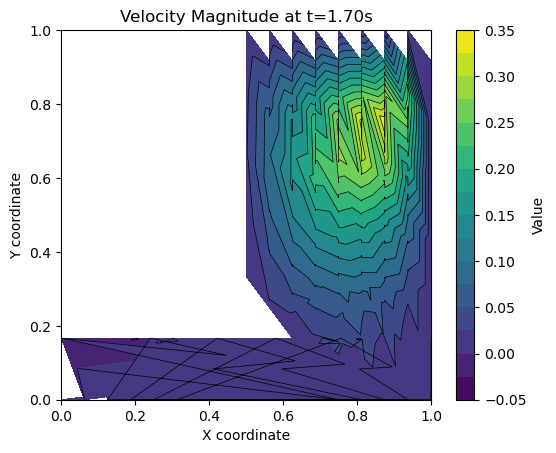


--- Solving Time Step 18/20 | t = 1.80s ---
  Newton iteration 1
    Residual Norm: 7.085e-02
  Newton iteration 2
    Residual Norm: 3.209e-04
  Newton iteration 3
    Residual Norm: 6.568e-09
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

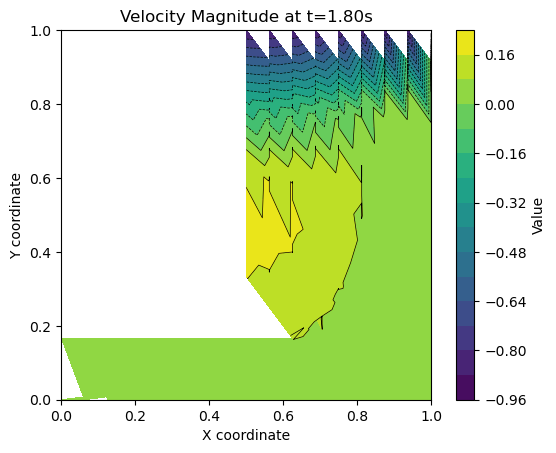

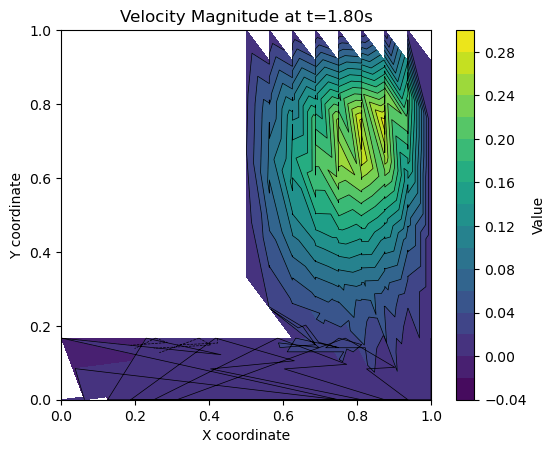


--- Solving Time Step 19/20 | t = 1.90s ---
  Newton iteration 1
    Residual Norm: 9.822e-02
  Newton iteration 2
    Residual Norm: 6.714e-04
  Newton iteration 3
    Residual Norm: 2.922e-08
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

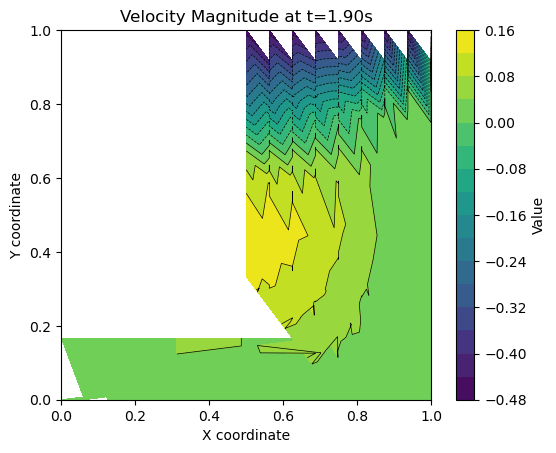

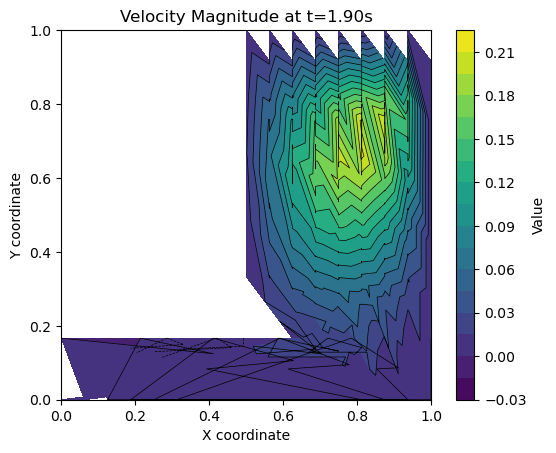


--- Solving Time Step 20/20 | t = 2.00s ---
  Newton iteration 1
    Residual Norm: 1.163e-01
  Newton iteration 2
    Residual Norm: 9.947e-04
  Newton iteration 3
    Residual Norm: 6.334e-08
    Newton converged in 3 iterations.
Plotting all components of 'u_n' as separate contour plots...


<Figure size 640x480 with 0 Axes>

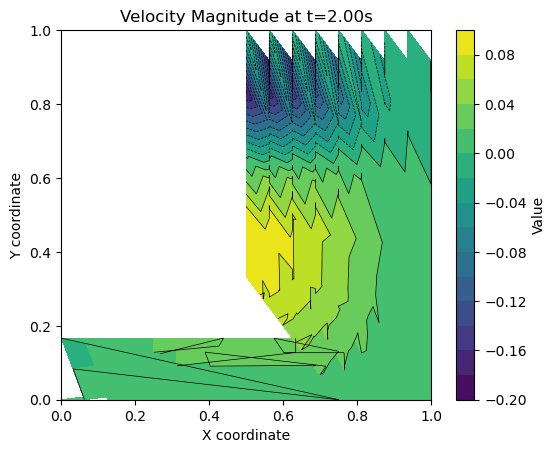

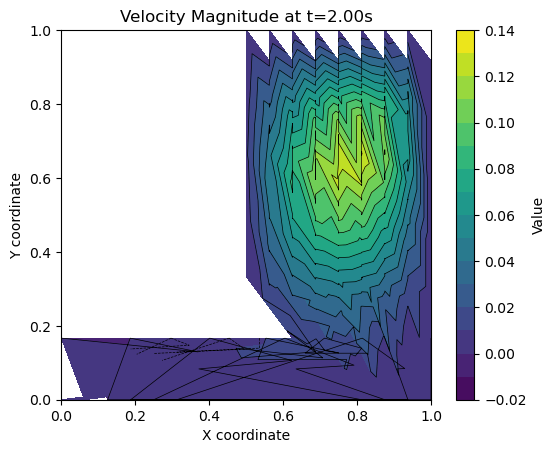


Simulation finished successfully!


In [4]:
# 3. ============================================================================
#    SOLVER LOOP (Corrected Implementation)
# ===============================================================================
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sp_la
from pycutfem.ufl.forms import assemble_form

# --- Simulation Parameters ---
T_end = DataBC.T  # Total simulation time
dt_val = dt.value
num_steps = int(T_end / dt_val)
newton_tol = 1e-6
max_newton_iter = 10

# --- Initialize Solution Functions ---
# Note: It's good practice to initialize to zero, but the first step of the
# time loop will set the correct state from u_n anyway.
u_k.nodal_values.fill(0.0)
p_k.nodal_values.fill(0.0)
u_n.nodal_values.fill(0.0)
p_n.nodal_values.fill(0.0)

# --- Apply Initial Conditions ---
# Use the new robust `apply_bcs` method. It correctly handles the mapping
# from global BCs to the specific DOFs within each function object.
print("Applying initial boundary conditions...")
dof_handler.apply_bcs(bcs, u_n, p_n)

# --- Main Time-Stepping Loop ---
for n in range(num_steps):
    t = (n + 1) * dt_val
    print(f"\n--- Solving Time Step {n+1}/{num_steps} | t = {t:.2f}s ---")

    # Set initial guess for Newton iteration: u_k = u_n, p_k = p_n
    u_k.nodal_values[:] = u_n.nodal_values[:]
    p_k.nodal_values[:] = p_n.nodal_values[:]
    
    # Apply non-homogeneous BCs to the initial guess for this time step.
    # This ensures the iteration starts from a state that respects the boundaries.
    dof_handler.apply_bcs(bcs, u_k, p_k)

    # --- Inner Newton Iteration Loop ---
    for k in range(max_newton_iter):
        print(f"  Newton iteration {k+1}")

        # Jacobian and Residual definitions (as provided by user)
        jacobian = (
            rho * dot(du, v) / dt
            + theta * rho * dot(dot(grad(u_k),du ), v)
            + theta * rho * dot(dot(grad(du),u_k ), v)
            + theta * mu * inner(grad(du), grad(v))
            - dp * div(v)
            + q * div(du)
        ) * dx()

        residual = (
                    # Time derivative: -(u_k - u_n)/dt ⋅ v
                    rho * dot(u_k - u_n, v) / dt  
                    + (rho*theta) * dot(  dot(grad(u_k),u_k, ) , v) 
                    + (rho - (rho*theta)) * dot(   dot(grad(u_n),u_n  ) , v) 
                    # Diffusion terms at theta and (1-theta)
                    +(theta * mu * inner(grad(u_k), grad(v)) ) 
                    +((1.0 - theta) * mu * inner(grad(u_n), grad(v)) ) 
                    
                    # Pressure terms
                    - p_k * div(v) 
                    # Continuity term
                    +q * div(u_k)  
                    
                    ) * dx()

        # Assemble Jacobian matrix A and residual vector R
        # We solve J*delta_U = -R, so we pass -residual to the assembler.
        A, R_vec = assemble_form(jacobian == -residual, dof_handler=dof_handler, bcs=bcs_homog, quad_order=6)
        
        norm_res = np.linalg.norm(R_vec)
        print(f"    Residual Norm: {norm_res:.3e}")

        if norm_res < newton_tol:
            print(f"    Newton converged in {k+1} iterations.")
            break
        
        # Solve the linear system for the correction dU = (du, dp)
        delta_U = sp_la.spsolve(A, R_vec)
        
        # --- Update the solution using the robust DofHandler methods ---
        # 1. Add the correction vector to the function objects.
        #    This handles the mapping from the global delta_U vector to the
        #    local data arrays of u_k and p_k.
        dof_handler.add_to_functions(delta_U, [u_k, p_k])

        # 2. Re-apply the non-homogeneous boundary conditions.
        #    The solver calculates a correction for ALL DOFs, including those
        #    on the boundary. We must "clamp" the boundary DOFs back to their
        #    prescribed values after the update.
        dof_handler.apply_bcs(bcs, u_k, p_k)

    else: # This runs if the for loop completes without breaking
        raise RuntimeError(f"Newton's method did not converge after {max_newton_iter} iterations at t={t:.2f}s.")

    # Update solution for the next time step
    u_n.nodal_values[:] = u_k.nodal_values[:]
    p_n.nodal_values[:] = p_k.nodal_values[:]

    # Optional: Plot solution at the end of the time step
    plt.figure()
    # u_n.plot(kind='quiver', title=f"Velocity Magnitude at t={t:.2f}s")
    u_n.plot(kind='contour', title=f"Velocity Magnitude at t={t:.2f}s")
    plt.show() # Make sure to show the plot
    
    # Optional: You can also plot pressure
    # plt.figure()
    # p_n.plot(title=f"Pressure at t={t:.2f}s")
    # plt.show()

print("\nSimulation finished successfully!")
